In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Flatten, BatchNormalization, Input ,concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
import glob
import os
import PIL
import time

from IPython import display

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/training_checkpoints_ahsd'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [7]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

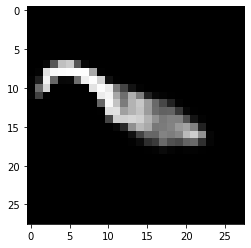

In [8]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [9]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
val = disc(sample)
print (val)

tf.Tensor([[-1.6841283]], shape=(1, 1), dtype=float32)


Now, we transfer the weights of discriminator to a new model, with the only difference being that the new model's last dense layer has 10 parameters instead of 1.

In [11]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = True  #Unfreezed as True

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [12]:
# view the initialized weights and bias of the last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-1].weights

[]

In [13]:
import pandas as pd
# Load the data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTrainImages 60k x 784.csv")
Y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTrainLabel 60k x 1.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTestImages 10k x 784.csv")
Y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds/csvTestLabel 10k x 1.csv")
Y_train = Y_train.values.reshape(Y_train.shape[0],).astype('float32')
Y_test = Y_test.values.reshape(Y_test.shape[0],).astype('float32')
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
np.random.seed(42)
trainsize = 30000  # number of training images we use, selected randomly
testsize = 9000
randtrain = np.random.choice(X_train.shape[0], trainsize, replace=False)
X_train, Y_train = X_train[randtrain], Y_train[randtrain]
randtest = np.random.choice(X_test.shape[0], testsize, replace=False)
X_test, Y_test = X_test[randtest], Y_test[randtest]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(30000, 28, 28, 1)
(30000,)
(9000, 28, 28, 1)
(9000,)


In [14]:
train_images = X_train.reshape((trainsize, 28, 28, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 28, 28, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(Y_train)
test_labels = to_categorical(Y_test)

In [16]:
import skimage.data as skid
import cv2
import pylab as plt
import numpy as np
import cv2
from sklearn.cluster import MiniBatchKMeans
import pickle
import tqdm.notebook as tqdm

def generate_vector(gray):
  Detector = cv2.xfeatures2d.SIFT_create() ## cv2.FastFeatureDetector.create()
  Descriptor = cv2.xfeatures2d.SIFT_create()
  vector_64 = np.zeros(64,dtype='uint8')
  step_size = 5
  gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  kp = Detector.detect(gray)
  if(len(kp)<8):
        return vector_64
  # kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
  #                                     for x in range(0, gray.shape[1], step_size)]
  kp, desc = Descriptor.compute(gray, kp)
  kmeans = MiniBatchKMeans(n_clusters=8, n_init=10)
  kmeans.fit(desc)
  predictions = kmeans.predict(X=desc,  sample_weight=None)
  for pre in predictions:
    vector_64[pre] +=1
  return vector_64

# multiple images train
stack_tr = generate_vector(X_train[0])
count = 0
for img in tqdm.tqdm(X_train[1:]):
    vector = generate_vector(img)
    stack_tr = np.vstack((stack_tr,vector))
    count +=1
print("Histogram Generated for training set! ")
# multiple images train
stack_ts = generate_vector(X_test[0])
count = 0
for img in tqdm.tqdm(X_test[1:]):
    vector = generate_vector(img)
    stack_ts = np.vstack((stack_ts,vector))
    count +=1
print("Histogram Generated for testing set! ")

  0%|          | 0/29999 [00:00<?, ?it/s]

Histogram Generated for training set! 


  0%|          | 0/8999 [00:00<?, ?it/s]

Histogram Generated for testing set! 


In [17]:
# np.save("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds_SIFT_histogram_train.npy",stack_tr)
# np.save("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds_SIFT_histogram_test.npy",stack_ts)
#
stack_tr = np.load("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds_SIFT_histogram_train.npy")
stack_ts = np.load("/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/ahds_SIFT_histogram_test.npy")

In [18]:
def ExtractFeatures_Layer(dim):
    model = Sequential()
    model.add(Dense(64,input_dim=dim,kernel_regularizer=l2(0.01)
                    ))
    model.add(Dropout(0.5))
    return model
DSIFT = ExtractFeatures_Layer(stack_tr.shape[1])
MergeModel = concatenate([new_model.output, DSIFT.output])

In [19]:
# new_model.add(Dense(10, activation='softmax'))
m = Dense(32, activation='relu')(MergeModel)
m = Dropout(0.5)(m)
m = Dense(10, activation='softmax')(m)

fin_model = Model(inputs=[new_model.input, DSIFT.input], outputs=m)
fin_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   1664        ['conv2d_input[0][0]']           
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 14, 14, 64)   0           ['conv2d[1][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 64)   0           ['leaky_re_lu_3[1][0]']          
                                                                                              

In [20]:
fin_model.compile(Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',tf.keras.metrics.CategoricalCrossentropy()])

In [21]:
train_images.shape, stack_tr.shape, train_labels.shape, stack_ts.shape

((30000, 28, 28, 1), (30000, 64), (30000, 10), (9000, 64))

In [22]:
filepath = "/content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_SIFT(only)NET_"+"ahds"+"_best_weights.hdf5"
early_stop = EarlyStopping(monitor='val_accuracy', patience=50,mode='max')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stop]

history2 = fin_model.fit([train_images,stack_tr], train_labels, batch_size=100, epochs=20
                        ,validation_data=([test_images,stack_ts], test_labels),
                         callbacks = callbacks_list,
                        ) 

Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8962 - categorical_crossentropy: 0.3236
Epoch 1: val_accuracy improved from -inf to 0.97789, saving model to /content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_SIFT(only)NET_ahds_best_weights.hdf5
300/300 [==============================] - 73s 239ms/step - loss: 0.4664 - accuracy: 0.8962 - categorical_crossentropy: 0.3236 - val_loss: 0.0748 - val_accuracy: 0.9779 - val_categorical_crossentropy: 0.0719
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9497 - categorical_crossentropy: 0.1616
Epoch 2: val_accuracy improved from 0.97789 to 0.98222, saving model to /content/drive/MyDrive/Colab Notebooks/SIFT+GAN handwriting/GAN_SIFT(only)NET_ahds_best_weights.hdf5
300/300 [==============================] - 68s 228ms/step - loss: 0.1621 - accuracy: 0.9497 - categorical_crossentropy: 0.1616 - val_loss: 0.0635 - val_accuracy: 0.9822 - val_categorical_

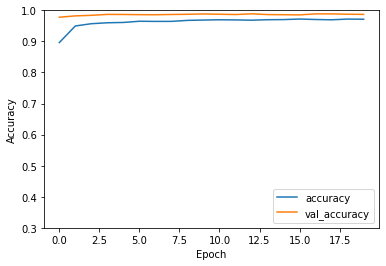

In [23]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

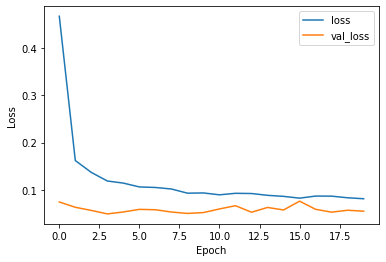

In [24]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure()
plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.90 after 15 epochs.

In [25]:
stack_ts[i].shape, stack_ts[i].reshape(1,64).shape, test_images[i].shape, test_images[i].reshape(1,28,28,1).shape

((64,), (1, 64), (28, 28, 1), (1, 28, 28, 1))

1/1 [==============================] - 0s 36ms/step
[[5.7335275e-10 6.5172301e-25 6.8908573e-10 5.2135481e-22 3.3260392e-15
  1.0000000e+00 4.5826881e-22 2.4110205e-16 5.7422491e-14 2.8142980e-13]]
prediction: 5


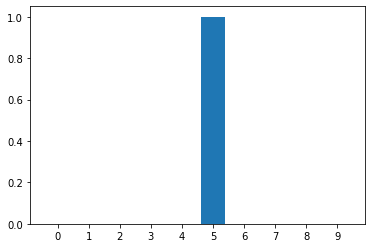

In [30]:
# demonstration: predict the ith test digit
i = 160
prediction = fin_model.predict([test_images[i].reshape(1,28,28,1),stack_ts[i].reshape(1,64)])

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), prediction[0,:])
plt.show()

actual label: 5


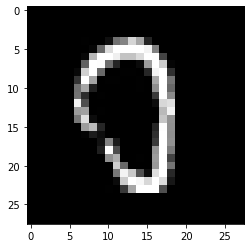

In [31]:
# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

In [32]:
pred_labels = fin_model.predict([test_images,stack_ts]).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

282/282 [==============================] - 5s 18ms/step


In [33]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(true_labels, pred_labels)
confusion_mat

array([[900,   3,   0,   2,   1,   5,   1,   0,   3,   0],
       [  9, 882,   1,   1,   0,   0,   0,   1,   1,   0],
       [  3,   2, 888,   6,   5,   0,   0,   0,   2,   0],
       [  1,   3,  10, 888,   0,   0,   0,   0,   0,   1],
       [  0,   2,   3,   1, 883,   0,   0,   0,   0,   1],
       [  9,   0,   8,   0,   0, 880,   0,   0,   0,   5],
       [  0,   3,   0,   0,   1,   0, 894,   0,   0,   5],
       [  1,   0,   0,   2,   0,   2,   2, 883,   0,   0],
       [  1,   0,   2,   1,   0,   0,   0,   0, 879,   0],
       [  0,   0,   2,   0,   1,   1,   2,   0,   1, 906]])

In [37]:
import numpy as np
confusion_mat = [[900,   3,   0,   2,   1,   5,   1,   0,   3,   0],
       [  9, 882,   1,   1,   0,   0,   0,   1,   1,   0],
       [  3,   2, 888,   6,   5,   0,   0,   0,   2,   0],
       [  1,   3,  10, 888,   0,   0,   0,   0,   0,   1],
       [  0,   2,   3,   1, 883,   0,   0,   0,   0,   1],
       [  9,   0,   8,   0,   0, 880,   0,   0,   0,   5],
       [  0,   3,   0,   0,   1,   0, 894,   0,   0,   5],
       [  1,   0,   0,   2,   0,   2,   2, 883,   0,   0],
       [  1,   0,   2,   1,   0,   0,   0,   0, 879,   0],
       [  0,   0,   2,   0,   1,   1,   2,   0,   1, 906]]
confusion_mat = np.array(confusion_mat)

Text(0.5, 15.0, 'Predicted label')

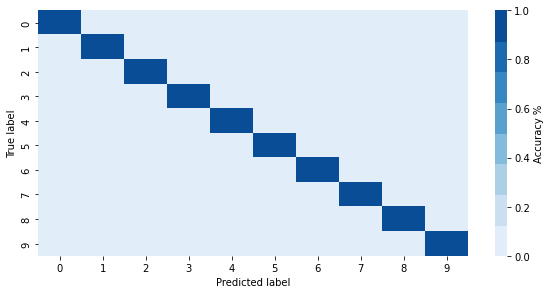

In [39]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)
fig, ax = plt.subplots(figsize=(8, 4))
import string
# classes = list(string.ascii_uppercase)
classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)
sns.heatmap(confusion_mat_df, ax=ax, cbar_kws={'label': 'Accuracy %'}, cmap=sns.color_palette("Blues",8))
# sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues, linewidths=.5, ax=ax, cbar_kws={'label': 'Accuracy %'})
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.show()

Text(0.5, 51.0, 'Predicted label')

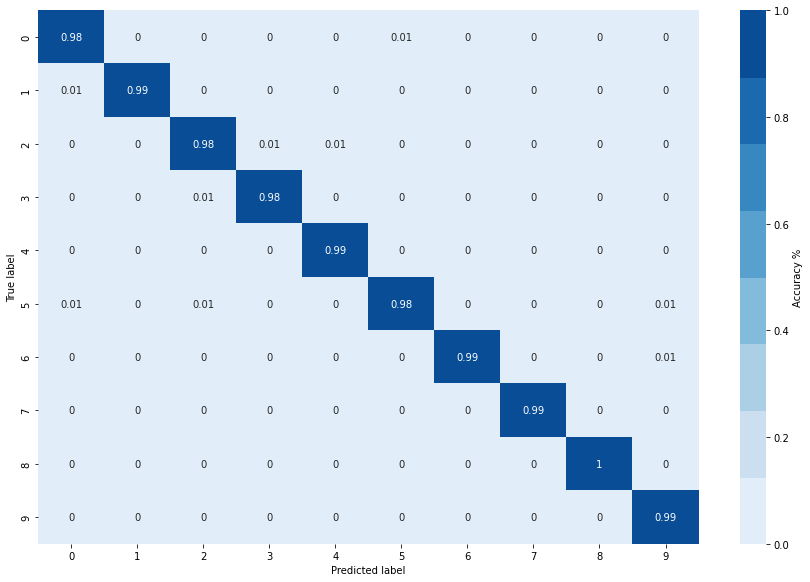

In [40]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

confusion_mat_norm = np.around(confusion_mat.astype('float') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)
fig, ax = plt.subplots(figsize=(12, 8))
import string
# classes = list(string.ascii_uppercase)
classes = np.arange(0,10).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = classes, 
                                columns = classes)
sns.heatmap(confusion_mat_df, ax=ax, annot=True, cbar_kws={'label': 'Accuracy %'}, cmap=sns.color_palette("Blues",8))
# sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues, linewidths=.5, ax=ax, cbar_kws={'label': 'Accuracy %'})
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.show()